In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Memuat data
df = pd.read_csv("transformed_segmentasi_final.csv")

# Konversi 'Genres Dominan' ke numerik dengan Label Encoding
df["Genres Dominan"] = df["Genres Dominan"].astype("category").cat.codes

# Pastikan 'Dominant Topic' juga numerik
if df["Dominant Topic"].dtype == 'object':
    df["Dominant Topic"] = df["Dominant Topic"].astype("category").cat.codes

# Pilih fitur numerik yang digunakan untuk segmentasi
features = [
    "Total Game",
    "Total Playtime",
    "Total Achievement",
    "Genres Dominan",
    "Dominant Topic"
]

X = df[features]

# Standarisasi fitur (rata-rata nol, variansi satu)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Menampilkan beberapa baris pertama dari data yang telah di-scaling
print("Matriks data X (5 baris pertama setelah scaling):\n", np.round(X_scaled[:5], 3))


Matriks data X (5 baris pertama setelah scaling):
 [[ 0.264  1.209  0.872  1.857 -1.007]
 [ 1.866  0.386 -0.119  0.006 -1.038]
 [ 2.63   1.468  1.143  1.05  -1.134]
 [-0.584 -0.921  0.15  -1.132 -0.34 ]
 [ 0.253 -0.201 -0.065 -0.468  1.026]]


In [3]:
# Jumlah archetype yang ingin ditemukan
k = 4

# Inisialisasi matriks bobot keanggotaan B (n x k) secara acak
np.random.seed(1)
B = np.abs(np.random.randn(X_scaled.shape[0], k))
B = B / B.sum(axis=1, keepdims=True)  # Normalisasi baris agar jumlahnya menjadi 1

# Hitung archetype awal Z = B.T * X
Z = B.T.dot(X_scaled)

# Menampilkan bobot keanggotaan awal dan archetype
print("Bobot keanggotaan awal (3 pemain pertama):")
print(np.round(B[:3], 3))

print("Archetype awal (2 fitur pertama dari setiap archetype):")
print(np.round(Z[:, :2], 3))


Bobot keanggotaan awal (3 pemain pertama):
[[0.423 0.159 0.138 0.28 ]
 [0.153 0.406 0.308 0.134]
 [0.078 0.061 0.357 0.504]]
Archetype awal (2 fitur pertama dari setiap archetype):
[[-5.153  1.829]
 [ 2.501 -1.366]
 [ 0.339 -2.472]
 [ 2.312  2.009]]


In [4]:
from scipy.optimize import minimize

# Menyelesaikan untuk A (setiap baris a_j) berdasarkan Z dan data X_scaled
A = np.zeros((k, X_scaled.shape[0]))

for j in range(k):
    Zj = Z[j, :]  # Archetype j saat ini (1×p)

    # Tujuan untuk a_j (minimalkan kesalahan rekonstruksi)
    fun = lambda a: np.linalg.norm(Zj - a.dot(X_scaled))**2

    # Pembatas untuk a_j (jumlahkan menjadi 1, dan a_j >= 0)
    cons = ({'type': 'eq', 'fun': lambda a: np.sum(a) - 1},
            {'type': 'ineq', 'fun': lambda a: a})

    res = minimize(fun, np.ones(X_scaled.shape[0])/X_scaled.shape[0], constraints=cons)
    A[j, :] = res.x

# Menampilkan sebagian matriks A (2 archetype pertama, 5 data pertama)
print("Matriks bobot archetype A (2 archetype pertama, 5 data pertama):")
print(np.round(A[:2, :5], 3))


Matriks bobot archetype A (2 archetype pertama, 5 data pertama):
[[-0. -0. -0.  0.  0.]
 [-0. -0. -0. -0. -0.]]


In [5]:
# Menyelesaikan untuk B (setiap baris b_i) berdasarkan Z dan data X_scaled
B = np.zeros((X_scaled.shape[0], k))

for i in range(X_scaled.shape[0]):
    xi = X_scaled[i, :]  # Data titik i (1×p)

    # Tujuan untuk b_i (minimalkan kesalahan rekonstruksi)
    fun = lambda b: np.linalg.norm(xi - b.dot(Z))**2

    res = minimize(fun, np.ones(k)/k, constraints=cons)
    B[i, :] = res.x

# Menampilkan bobot keanggotaan untuk 5 pemain pertama setelah pembaruan
print("Bobot keanggotaan B (5 pemain pertama):")
print(np.round(B[:5], 3))


Bobot keanggotaan B (5 pemain pertama):
[[ 0.221  0.215 -0.     0.564]
 [ 0.195  0.361  0.033  0.411]
 [ 0.118  0.266  0.     0.617]
 [ 0.315  0.182  0.423  0.08 ]
 [ 0.203  0.242  0.408  0.147]]


In [6]:
# Iterasi pembaruan hingga konvergensi atau jumlah iterasi tetap
for it in range(10):  # Ganti dengan jumlah iterasi yang diinginkan
    # Pembaruan A berdasarkan B saat ini (Z = B^T X)
    Z = B.T.dot(X_scaled)

    A = np.zeros((k, X_scaled.shape[0]))

    for j in range(k):
        Zj = Z[j, :]
        res = minimize(lambda a: np.linalg.norm(Zj - a.dot(X_scaled))**2, np.ones(X_scaled.shape[0])/X_scaled.shape[0], constraints=cons)
        A[j, :] = res.x

    # Pembaruan Z = A * X
    Z = A.dot(X_scaled)

    # Pembaruan B berdasarkan Z yang baru
    for i in range(X_scaled.shape[0]):
        xi = X_scaled[i, :]
        res = minimize(lambda b: np.linalg.norm(xi - b.dot(Z))**2, np.ones(k)/k, constraints=cons)
        B[i, :] = res.x

# Menampilkan keanggotaan akhir
print("Definisi akhir archetype (Z) dan keanggotaan (B) diperoleh.")


Definisi akhir archetype (Z) dan keanggotaan (B) diperoleh.


In [7]:
# Menetapkan label (indeks archetype dengan keanggotaan maksimum untuk setiap pemain)
labels = np.argmax(B, axis=1)

# Membuat DataFrame dengan skor keanggotaan dan label segmen
df_membership = pd.DataFrame(B, columns=[f'Archetype_{j+1}' for j in range(k)])
df_membership['Segment_Label'] = labels

# Menggabungkan dengan data pemain asli
result_df = df[['Steam ID']].join(df_membership)

# Menampilkan skor keanggotaan untuk 5 pemain pertama
pd.set_option('display.float_format', '{:.4f}'.format)
print(result_df.head(5))


            Steam ID  Archetype_1  Archetype_2  Archetype_3  Archetype_4  \
0  76561197960269409       0.2109       0.6700      -0.0000       0.1191   
1  76561197962437769       0.0225       0.4869       0.2060       0.2846   
2  76561197963260222       0.1604       0.4605       0.0000       0.3791   
3  76561197963740541       0.1107       0.2684       0.6210       0.0000   
4  76561197964099717       0.0651       0.1230       0.7113       0.1006   

   Segment_Label  
0              1  
1              1  
2              1  
3              2  
4              2  


In [8]:
# Menyimpan DataFrame hasil segmentasi ke dalam file CSV
result_df.to_csv("segmentation_result.csv", index=False)

print("Hasil segmentasi pemain telah disimpan di segmentation_result.csv.")


Hasil segmentasi pemain telah disimpan di segmentation_result.csv.


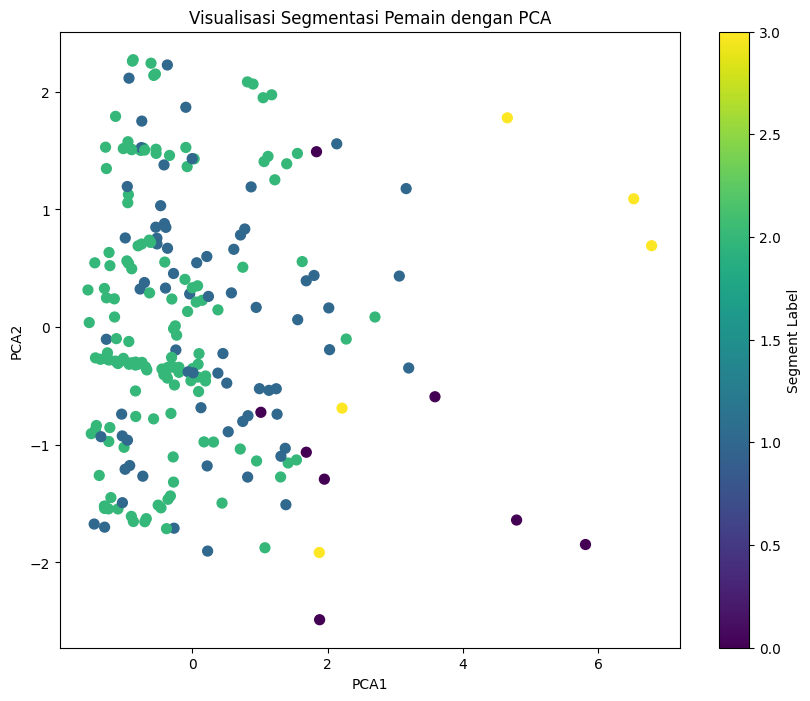

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Menggunakan PCA untuk mereduksi dimensi menjadi 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Menambahkan label segmen ke dalam data PCA
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
X_pca_df["Segment_Label"] = result_df["Segment_Label"]

# Scatter plot berdasarkan hasil PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_df["PCA1"], X_pca_df["PCA2"], c=X_pca_df["Segment_Label"], cmap='viridis', s=50)
plt.colorbar(label='Segment Label')
plt.title("Visualisasi Segmentasi Pemain dengan PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


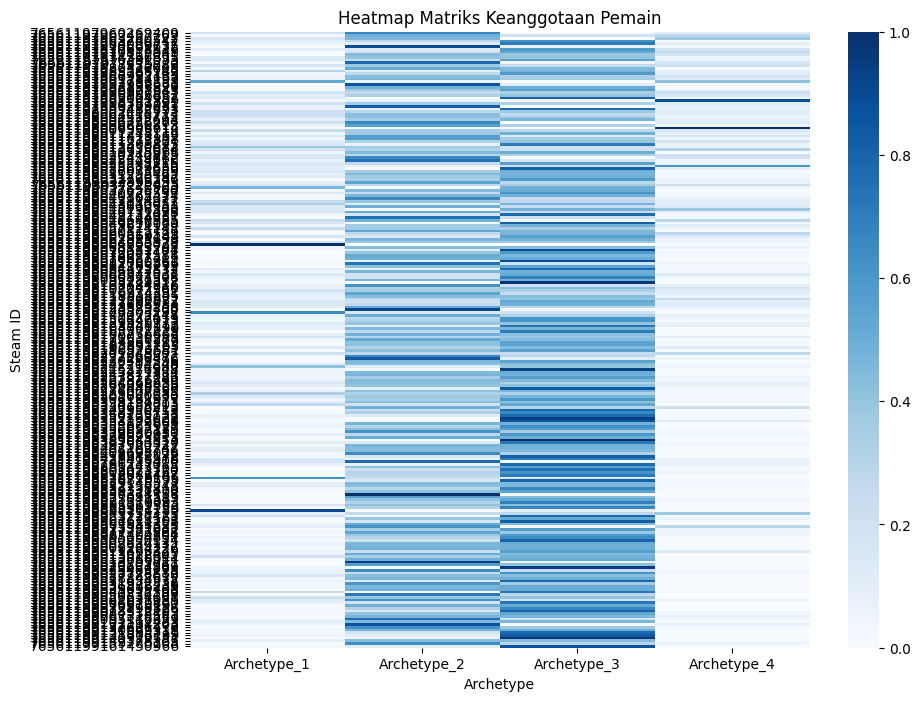

In [10]:
import seaborn as sns

# Visualisasi matriks keanggotaan (B) sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(B, cmap='Blues', xticklabels=[f'Archetype_{i+1}' for i in range(k)], yticklabels=df['Steam ID'].values, cbar=True)
plt.title("Heatmap Matriks Keanggotaan Pemain")
plt.xlabel("Archetype")
plt.ylabel("Steam ID")
plt.show()


In [11]:
# Memuat data dari kedua file CSV
seg_result_df = pd.read_csv('segmentation_result.csv')
seg_transformed_df = pd.read_csv('segmentation_transformed.csv')

# Menggabungkan kedua DataFrame berdasarkan Steam ID
merged_df = seg_result_df.merge(seg_transformed_df, on='Steam ID', how='left')

# Menampilkan data gabungan
merged_df.head()


,Steam ID,Archetype_1,Archetype_2,Archetype_3,Archetype_4,Segment_Label,Game_Count,Total_Playtime,Normalized_Playtime,Total_Achievements,Dominant_Genre,Dominant_Genre_Label,App ID,Game Name,Playtime (hours),Genres,Achievements,Topic
0,76561197960269409,0.2109,0.6700,-0.0000,0.1191,1,491.0000,8530.6333,0.4518,6145.0000,"Action, RPG",25.0000,22380.0000,fallout: new vegas,139.4667,"Action, RPG",53.0000,"[2, 25, 37]"
1,76561197962437769,0.0225,0.4869,0.2060,0.2846,1,696.0000,3599.1333,0.1888,2325.0000,"Action, RPG",25.0000,1245620.0000,elden ring,142.8333,"Action, RPG",8.0000,"[52, 66, 134]"
2,76561197963260222,0.1604,0.4605,0.0000,0.3791,1,597.0000,6718.6000,0.3552,6567.0000,"Indie, RPG, Strategy",51.0000,763890.0000,wildermyth,156.9500,"Indie, RPG, Strategy",53.0000,"[96, 155, 161]"
3,76561197963740541,0.1107,0.2684,0.6210,0.0000,2,64.0000,358.8833,0.0159,3697.0000,Action,0.0000,381210.0000,dead by daylight,142.1000,Action,82.0000,"[257, 39, 42]"
4,76561197964099717,0.0651,0.1230,0.7113,0.1006,2,253.0000,2782.6167,0.1452,2489.0000,"Free To Play, Indie, Strategy",47.0000,291410.0000,duelyst,152.6833,"Free To Play, Indie, Strategy",9.0000,[41]


In [12]:
# Membuat fungsi untuk mendapatkan genre dan topik dominan
def get_dominant_genre_topic(group):
    # Mendapatkan genre dan topik dominan
    genres = group['Dominant_Genre'].value_counts().nlargest(3).index.tolist()
    topics = group['Topic'].value_counts().nlargest(3).index.tolist()
    return pd.Series({
        'Dominant_Genre': ', '.join(genres),
        'Topic': ', '.join(topics)
    })

# Mengelompokkan data berdasarkan archetype dan menghitung rata-rata
result = merged_df.groupby('Segment_Label').agg(
    Avg_Playtime=('Total_Playtime', 'mean'),
    Avg_Owned_Game=('Game_Count', 'mean'),
    Avg_Achievement=('Total_Achievements', 'mean')
)

# Menambahkan genre dan topik dominan untuk setiap archetype
dominant_info = merged_df.groupby('Segment_Label').apply(get_dominant_genre_topic)

# Menggabungkan hasilnya
final_result = result.join(dominant_info)

# Menampilkan hasil akhir
final_result.reset_index(inplace=True)
final_result.rename(columns={'Segment_Label': 'Archetype'}, inplace=True)

# Menyimpan hasil ke dalam file CSV
final_result.to_csv('archetype_characteristics.csv', index=False)

final_result.head()


/var/folders/kh/7d1scz1n2f7gnm2sy2q4rgs00000gn/T/ipykernel_42782/1670351151.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dominant_info = merged_df.groupby('Segment_Label').apply(get_dominant_genre_topic)


,Archetype,Avg_Playtime,Avg_Owned_Game,Avg_Achievement,Dominant_Genre,Topic
0,0,4961.4976,387.0000,14687.0000,"RPG, Casual, Free To Play, Indie, Strategy, Ac...","[], [273], [206, 333, 13]"
1,1,3131.1602,231.1571,2002.5000,"Action, Strategy, Action, RPG","[], [15, 78, 127], [2, 25, 37]"
2,2,2555.5639,203.9914,2130.3534,"Action, Action, Adventure, RPG","[], [13, 15, 17], [23, 56, 87]"
3,3,11234.8083,1706.2500,7850.7500,"Casual, Indie, RPG, Strategy, Indie, Strategy","[], [232, 490], [14, 57, 222]"


In [13]:
# Evaluasi Reconstruction Error
# X_scaled ≈ B @ Z

X_reconstructed = B.dot(Z)
reconstruction_error = np.linalg.norm(X_scaled - X_reconstructed, ord='fro') ** 2

print("Reconstruction Error (RE):", reconstruction_error)


Reconstruction Error (RE): 435.85988538485094
